In [29]:
!pip install graphdatascience wordcloud matplotlib Pillow scikit-multilearn==0.2.0 scikit-learn==1.2.1  seaborn==0.12.2

In [30]:
import numpy as np
import pandas as pd

from graphdatascience import GraphDataScience

from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.problem_transform import LabelPowerset

from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 100)
sns.set(rc={"figure.figsize": (16, 9)})

# Enhancing Word Embedding with Graph Neural Networks
## Leverage GraphSAGE algorithm in combination with OpenAI word embeddings to  increase downstream document classification accuracy

Natural Language Processing (NLP) has seen rapid advancements in recent years. One important aspect of this progress has been the use of embeddings, which are numerical representations of words or phrases that capture their meaning and relationships to other words in a language. Embeddings can be used in a wide range of NLP tasks, such as document classification, machine translation, sentiment analysis, and named entity recognition. Furthermore, with the availability of large pre-trained language models like GPT-3, embeddings have become even more critical for enabling transfer learning across a range of language tasks and domains. As such, embeddings are closely tied to the rapid advancements in NLP.

On the other hand, recent advancements in graphs and graph neural networks have led to improved performance on a wide range of tasks, including image recognition, drug discovery, and recommender systems. In particular, graph neural networks have shown great promise in learning representations of graph-structured data, where the relationships between data points provide a signal that improves the accuracy of downstream machine-learning tasks.
In this blog post, you'll discover how to harness the power of graph neural networks to capture and encode the relationships between data points and enhance document classification accuracy. Specifically, you will train two models to predict a medium article's tags.

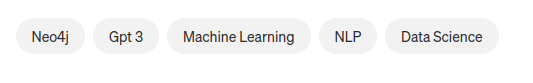

Most medium articles have relevant tags assigned to them by the author for easier discoverability and search performance. Additionally, you can think of these tags as a categorization of articles. Each article can have up to 5 tags or categories it belongs to, as shown in the above image. Therefore you will train two classification models to perform a *multi-label classification*, where each article can have one or more tags assigned to them.

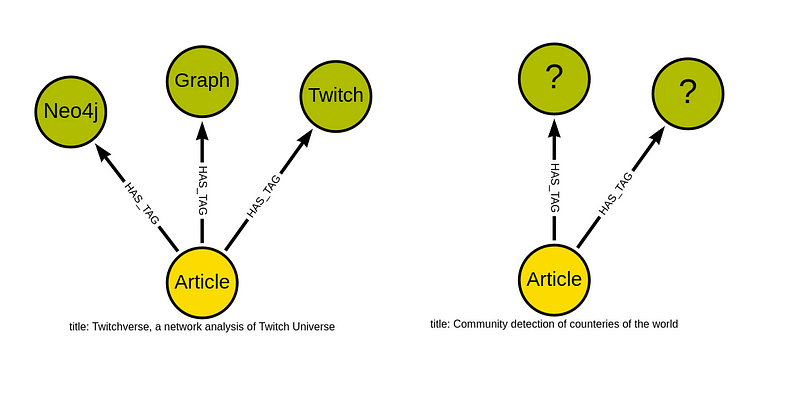

The first classification model will use OpenAI's latest embeddings (text-embedding-ada-002) of the article's title and subtitle as the input features. This model will provide a baseline accuracy you will try to improve using a graph neural network algorithm called GraphSAGE. Interestingly, word embeddings can be and will be used in this example as input to GraphSAGE. During training, the GraphSAGE algorithm then leverages these word embeddings to iteratively aggregate information from neighboring nodes, resulting in powerful node-level representations that can improve the accuracy of downstream machine-learning tasks like document classification.

In short, this blog post explores the use of graph neural networks to improve word embeddings by taking into account the relationships between data points. When the relationships between data points are relevant and predictive, graph neural networks can learn more meaningful and accurate representations of text data and, consequently, increase the accuracy of downstream machine learning models.

## Medium dataset

There are a couple of medium article datasets available on Kaggle. However, none of them contain any relationships between articles. What type of relationships between articles would even be predictive for predicting their tags? Medium has added the ability for users to create lists that can help them bookmark and curate the content they have or intend to read.

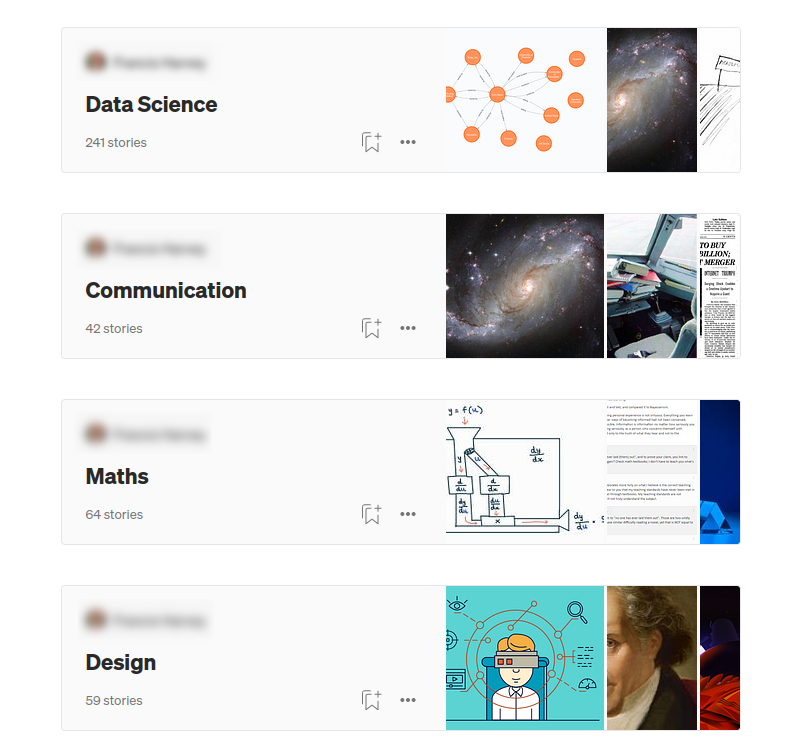

This image presents an example where the user created four lists of articles based on their topics. For example, most articles were grouped under the Data Science list, while other articles were added to the Communication, Maths, and Design lists. The idea is that if two articles are in the same list, they are somewhat more similar than if they don't have any common lists. You can think of medium lists as human-annotated relationships between articles that can help you find and potentially recommend similar articles.

Unfortunately, there are no publicly available datasets with information about the Medium articles as well as the user lists they belong to. Therefore, I had to spend an afternoon parsing the data. I retrieved information about 55 thousand medium articles from 4000 user lists.
## Preparing Neo4j environment
The graph construction and GraphSAGE training will be executed in Neo4j. I like Neo4j as it offers a nicely designed graph query language called Cypher as well as a Graph Data Science plugin that contains more than 50 graph algorithms that cover most of graph analytics workflow. Therefore, there is no need to use multiple tools to create and analyze the graph.
The graph schema of the Medium dataset if the following:

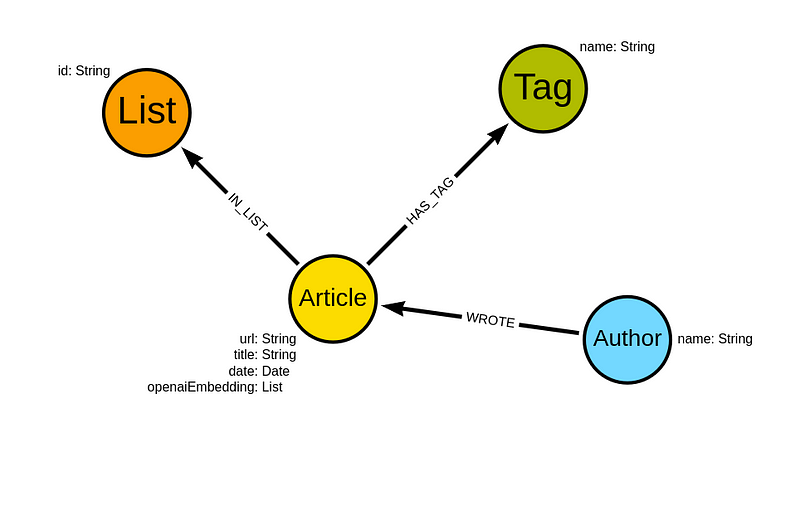

The schema revolves around Medium articles. We know the url, title, and date of the article. Additionally, I have calculated the OpenAI's embeddings using the text-embedding-ada-002 model based on the article title and subtitle and stored them as openaiEmbedding property. Additionally, we know who wrote the article, which users lists it belongs to, and its tags.

I have prepared two options for you to import the medium dataset into Neo4j database. 

* You can execute the following Jupyter notebook and import the dataset from Python. https://github.com/tomasonjo/blogs/blob/master/medium/Import.ipynb
* The other option is to restore the Neo4j database dump I have prepared. https://drive.google.com/file/d/1HLywpCBwEMYs6wZee0WHpZJxw3HtoqNn/view

The dump has been created with Neo4j version 5.5.0, so make sure to use that version or later. The easiest way to restore the database dump is to use the Neo4j Desktop environment. Additionally, you will need to install the APOC and GDS libraries if you are using the Neo4j Desktop environment.

In [5]:
host = "bolt://localhost:7687"
user = "neo4j"
password = "pleaseletmein"

gds = GraphDataScience(host, auth=(user, password))

# Exploratory analysis
We will be using the Graph Data Science Python Client to interface with Neo4j and its Graph Data Science plugin. It is an excellent addition to the Neo4j ecosystem, allowing us to execute graph algorithms using pure Python code. Check out my introductory blog post for more information.
First, we will evaluate the distribution of tags per medium article.

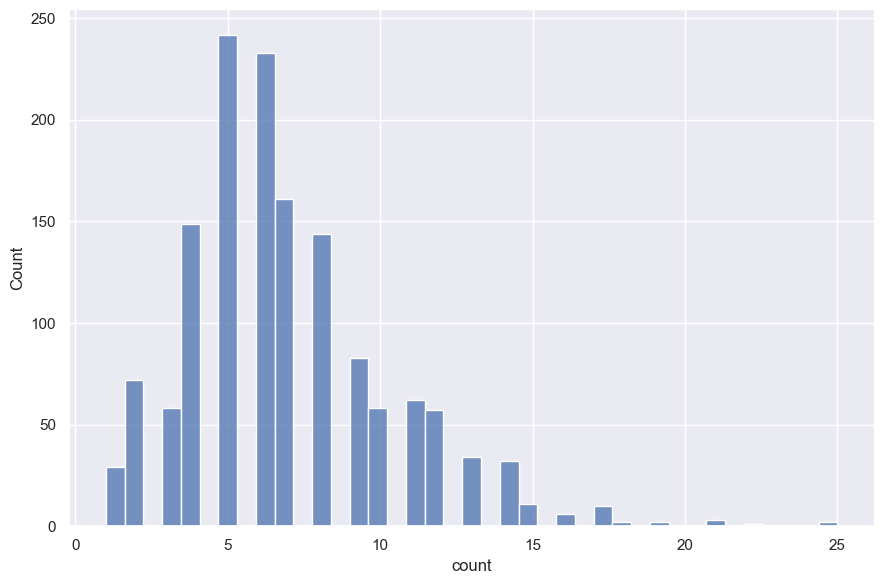

In [6]:
dist_df = gds.run_cypher("""
MATCH (a:Recipie)
RETURN count{(a)-[:HAS_INGREDIENT]->()} AS count
""")

sns.displot(dist_df['count'], height=6, aspect=1.5)

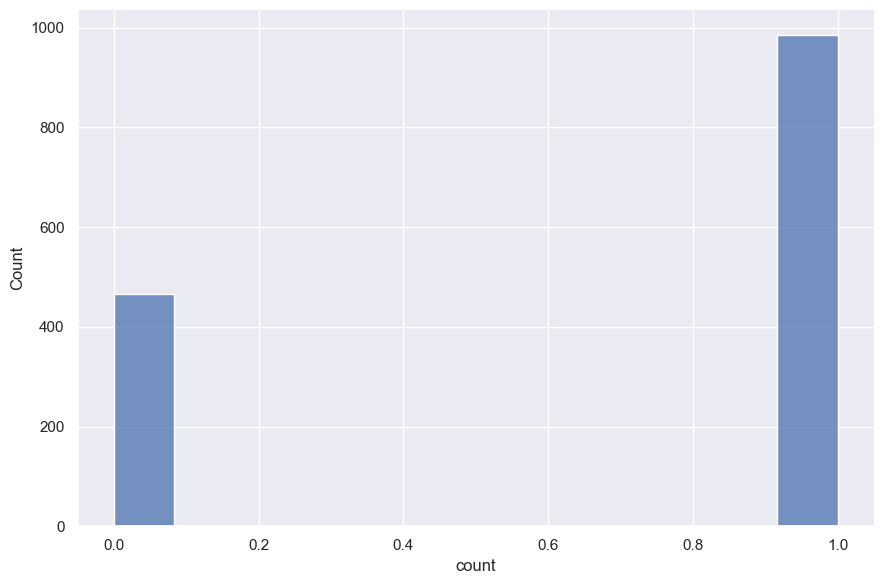

In [8]:
dist_df = gds.run_cypher("""
MATCH (a:Recipie)
RETURN count{(a)-[:IS_PART_OF_MENU]->()} AS count
""")

sns.displot(dist_df['count'], height=6, aspect=1.5)

Around 50% of articles have no tags present. There are two reasons for that. Either the author did not use any, or the scrapping process failed to retrieve them for various reasons, like medium publications having custom HTML structures. However, it is not a big deal as we still have more than 25 thousand articles with their tags present, allowing us to train and evaluate the multi-label classification model of article tags. Most authors choose to use five tags per article, which is also the upper limit that the Medium platform allows.

Next, we will evaluate if any articles are not part of any user lists.

In [14]:
gds.run_cypher(
    """
MATCH (a:Article)
RETURN exists {(a)-[:IN_LIST]-()} AS in_list,
       count(*) AS count
ORDER BY count DESC
"""
)

,in_list,count


The results show that all articles belong to at least one list. Identifying isolated nodes (nodes with no connection) is a critical part of any graph analytics workflow, as we have to pay special attention to them while calculating node embeddings. Luckily, this dataset contains no isolated nodes, so we don't have to worry about that.

In the last part of the exploratory analysis, we will examine the most frequent tags. Here, we will construct a word cloud of tags present in at least 100 articles.

<Axes: ylabel='Count'>

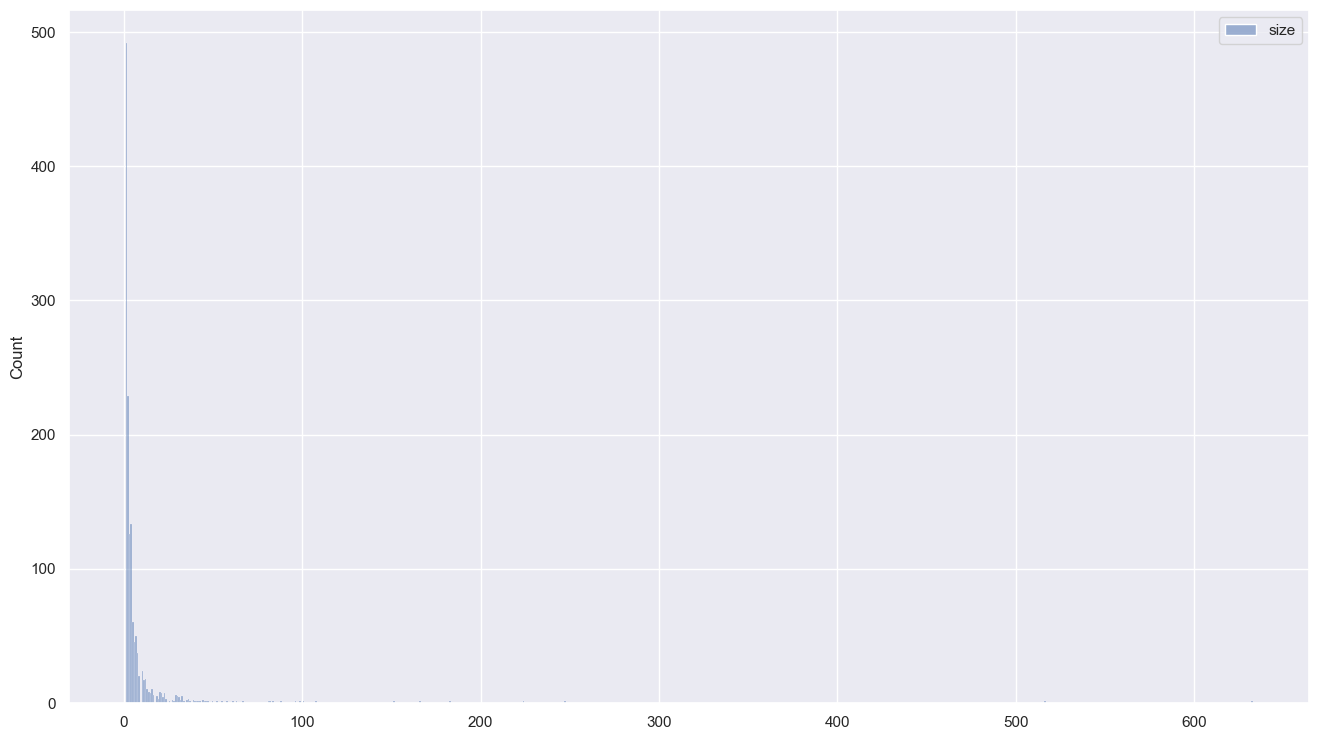

In [45]:
tags = gds.run_cypher(
    """
MATCH (t:Ingredient)
WITH t, count {(t)<--()} AS size
RETURN t.title AS tag, size
ORDER BY size DESC
"""
)

sns.histplot(tags)

In [50]:
analysis = gds.run_cypher("""
MATCH (i:Ingredient)
RETURN AVG(count {(i)<--()}) AS average_degree
""")
analysis

,average_degree
0,7.206452


In [59]:
page_rank = gds.run_cypher("""
CALL gds.pageRank.stats('myGraph', {
  maxIterations: 20,
  dampingFactor: 0.85
})
YIELD *
""")
page_rank

,ranIterations,didConverge,centralityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,1,True,"{'min': 0.14999961853027344, 'max': 0.14999961853027344, 'p90': 0.14999961853027344, 'p999': 0.1...",502,0,39,"{'jobId': '02400a8b-951c-4c0e-8bf5-959b725729b4', 'scaler': 'NONE', 'logProgress': True, 'nodeLa..."


In [61]:
page_rank["centralityDistribution"][0]

{'min': 0.14999961853027344,
 'max': 0.14999961853027344,
 'p90': 0.14999961853027344,
 'p999': 0.14999961853027344,
 'p99': 0.14999961853027344,
 'p50': 0.14999961853027344,
 'p75': 0.14999961853027344,
 'p95': 0.14999961853027344,
 'mean': 0.14999961853027344}

# Multi-label classification
As mentioned, we will train a multi-label classification model to predict tags of a Medium article. Therefore, we will use the scikit-multilearn library to help with data splitting and model training. I noticed that the dataset split with scikit-multilearn library does not provide a random seed parameter, and therefore, the dataset split is not deterministic. For a proper comparison of the baseline model trained on OpenAI's word embedding and a model based on GraphSAGE embeddings, we will perform a single dataset split so that both model versions use the same training and test examples. Otherwise, there could be some differences between the models' accuracy based solely on the dataset split.
The word embeddings are already stored in the graph, so we only need to calculate the node embeddings using the GraphSAGE algorithm before we can train the classification models.

# Monopartite projection with Node Similarity algorithm
GraphSAGE supports graphs with multiple types of nodes, where each type of node has different features representing it. In our example, we have Article and List nodes. However, I have decided to simplify the workflow by performing a monopartite projection.

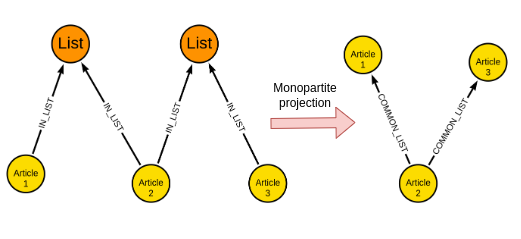

Monopartite projection is a frequent step in graph analysis. The idea is to take a bipartite graph (graph with two node types) and output a monopartite graph (graph with only one node type). In this specific example, we can create a relationship between two articles if they are part of the same list. Additionally, the number of shared lists or a normalized value like the Jaccard coefficient can be stored as a relationship property.

Since the monopartite projection is a common step in graph analysis, the Neo4j Graph Data Science library offers a Node Similarity algorithm to help us with it.

First, we need to project an in-memory graph. We will include the Article and List nodes along with the IN_LIST relationships. Additionally, we will include the openaiEmbedding node properties.


In [ ]:
G, metadata = gds.graph.project(
    "articles", ["Article", "List"], "IN_LIST", nodeProperties=["openaiEmbedding"]
)

Now we can perform the monopartite projection using the Node Similarity algorithm. One thing to note is that the default value of the *topK* parameter is 10, meaning that each node will be connected to only its ten most similar nodes. However, in this example, we want to create a relationship between all articles in the user list. Therefore, we will use a relatively high value of the topK parameter.

In [ ]:
gds.nodeSimilarity.mutate(
    G, topK=2000, mutateProperty="score", mutateRelationshipType="SIMILAR"
)

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

preProcessingMillis                                                                                                         0
computeMillis                                                                                                           28909
mutateMillis                                                                                                             1532
postProcessingMillis                                                                                                       -1
nodesCompared                                                                                                           54933
relationshipsWritten                                                                                                 12576142
similarityDistribution    {'p1': 0.05263155698776245, 'max': 1.0000075697898865, 'p5': 0.08333343267440796, 'p90': 1.00000...
configuration             {'topK': 2000, 'similarityMetric': 'JACCARD', 'bottomK': 10, 'bottomN': 0, 'mutateRelationsh

# Training the GraphSAGE model

The GraphSAGE algorithm is inductive, meaning that it can be used to generate embeddings for nodes that were previously unseen during training. The inductive nature allows us to train the GraphSAGE model only on a subset of the graph and then generate the embeddings for all the nodes. Training the GraphSAGE model only on a subset of the graph saves us time and compute power, which is useful when dealing with large graphs. While our graph is not that large, we can use this example to demonstrate how to sample the training subset of the graph efficiently.
# Random walk with restarts sampling

The idea behind random walk with restarts sampling is quite simple. The algorithm takes random walks from a set of predefined start nodes. At each step of the walk, there is a probability that the current random walk stops and a new one starts from the set of start nodes. The user can define the start nodes. If no start nodes are defined, the algorithm chooses them uniformly at random.

I thought it would be interesting to show you an example of choosing a start node manually. So we will begin by executing the Weakly Connected Components algorithm to evaluate how connected the graph of articles is. A weakly connected component is a set of nodes within the graph where a path exists between all nodes in the set if the direction of relationships is ignored.
A weakly connected component can be considered an island that nodes from other components cannot reach.

While the algorithm identifies connected sets of nodes, its output can help you evaluate how disconnected the overall graph is.

In [ ]:
wcc = gds.wcc.stream(G)

In [ ]:
wcc_grouped = (
    wcc.groupby("componentId")
    .size()
    .to_frame("componentSize")
    .reset_index()
    .sort_values("componentSize", ascending=False)
    .reset_index()
)
wcc_grouped

,index,componentId,componentSize
0,1,20,54802
1,7,149,368
2,4,124,193
3,23,374,134
4,16,288,117
...,...,...,...
599,493,25649,2
600,475,23247,2
601,490,25232,2
602,372,14429,2


There is a total of 604 connected components in our graph. The largest component contains 98% of all nodes, while the other ones are smaller, with many containing only two nodes. If a component contains only two nodes, it means that we have a medium user list that has only two articles in it, and those two articles are not part of any other lists.

We executed the Weakly Connected Component algorithm to identify a node that belongs to a large connected component and, therefore, can be used as a starting node of the sampling algorithm. For example, if we used a node with only one neighbor, the sampling algorithm couldn't perform longer walks to subsample the graph efficiently.

Fortunately, the sampling algorithm is implemented to automatically expand the set of start nodes if the random walks do not visit any new nodes. However, as we have used a start node from the largest connected component with 98% of all nodes, the algorithm won't have to expand the set of start nodes automatically.

In [ ]:
largest_component = wcc_grouped["componentId"][0]
start_node = wcc[wcc["componentId"] == largest_component]["nodeId"][0]

trainG, metadata = gds.alpha.graph.sample.rwr(
    "trainGraph",
    G,
    samplingRatio=0.20,
    startNodes=[int(start_node)],
    nodeLabels=["Article"],
    relationshipTypes=["SIMILAR"],
)

The sampling ratio parameter defines the fraction of nodes in the original graph to be sampled. For example, when using the value 0.20 for the sampling ratio, the sampled subgraph will be 20% the size of the original graph. Additionally, we need to define that the random walks can only visit Article nodes through SIMILAR relationships by using the nodeLabels and relationshipTypes parameters.

# GraphSAGE training

Finally, we can go ahead and train the GraphSAGE model on the sampled subgraph.

In [ ]:
%%time
gds.beta.graphSage.train(
    trainG,
    modelName="articleModel",
    embeddingDimension=256,
    sampleSizes=[10, 10],
    searchDepth=15,
    epochs=20,
    learningRate=0.0001,
    activationFunction="RELU",
    aggregator="MEAN",
    featureProperties=["openaiEmbedding"],
    batchSize=10,
)

CPU times: total: 15.6 ms
Wall time: 1min 19s


(GraphSageModel({'modelInfo': {0: {'modelName': 'articleModel', 'modelType': 'graphSage', 'metrics': {'ranIterationsPerEpoch': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'iterationLossesPerEpoch': [[26.26019890709872, 26.156118405129234, 26.006712545147508, 25.92684456378698, 25.575018540458483, 25.233838042043317, 25.067721677112406, 24.454238545866506, 24.130776361866218, 23.855447812576283], [22.88812883665899, 22.75306774219593, 22.05075688451951, 21.10843748023248, 20.731906072992217, 21.216923921795864, 20.59486753203335, 20.130998986574916, 19.185815405419945, 19.06932537041294], [18.511604223926863, 19.522669734079425, 18.400375298259693, 19.387847961155238, 18.237012133466642, 18.219625528092546, 17.353690309428497, 17.699450553469205, 17.83412123059852, 18.179846293207596], [17.120774782891676, 17.4705243547433, 17.662944284253353, 17.257237159855592, 16.84714168164934, 17.14394921485289, 16.61470931223102, 17.109660609480617, 17.6142637

The GraphSAGE algorithm will use the openaiEmbedding node property as input features. The GraphSAGE embeddings will have a dimension of 256 (vector size). While I have played around with hyper-parameter optimization for this blog, I have noticed that the learning rate and activation function are the most impactful parameters.

# Generate embeddings

After the GraphSAGE model has been trained, we can use it to calculate the node embeddings for all the Article nodes in the original larger projected graph and consider only the SIMILAR relationships.

In [ ]:
gds.beta.graphSage.write(
    G,
    modelName="articleModel",
    nodeLabels=["Article"],
    writeProperty="graphSAGE",
    relationshipTypes=["SIMILAR"],
)

GraphSage:   0%|          | 0/100 [00:00<?, ?%/s]

nodeCount                                                                                                              54933
nodePropertiesWritten                                                                                                  54933
preProcessingMillis                                                                                                        0
computeMillis                                                                                                          70129
writeMillis                                                                                                             2473
configuration            {'jobId': '1417c839-6841-49d3-a09f-9d18440c28bc', 'modelName': 'articleModel', 'writeConcurrency...
Name: 0, dtype: object

This time, we used the write mode to store the GraphSAGE embeddings as node properties in the database.

In [ ]:
trainG.drop()
G.drop()

graphName                                                                                                           articles
database                                                                                                               neo4j
memoryUsage                                                                                                                 
sizeInBytes                                                                                                               -1
nodeCount                                                                                                              59304
relationshipCount                                                                                                   12663437
configuration                                                                                                             {}
density                                                                                                             0.003601


# Classification model
We have prepared both the OpenAI and GraphSAGE embeddings. The only thing left is to train the models and compare their performance.

First, we will label the article tags we want to predict. I arbitrarily decided to only include tags that are present in at least 100 articles. The target tags will be labeled with a secondary Target label.

In [ ]:
# Tag relevant tags
gds.run_cypher(
    """
MATCH (t:Tag)
WHERE count{(t)<--()} > 100
SET t:Target
RETURN count(*) AS count
"""
)

,count
0,161


We have labeled 161 tags we want to predict. Remember, the word cloud visualization above took the same 161 tags and visualized them according to their frequencies.

As we will use the scikit-multilearn library, we need to export the relevant information from Neo4j.

In [ ]:
data = gds.run_cypher(
    """
MATCH (a:Article)-[:HAS_TAG]->(tag:Target)
RETURN a.url AS article,
        a.openaiEmbedding AS openai,
        a.graphSAGE AS graphSAGE,
        collect(tag.name) AS tags
"""
)

Next, we need to construct a binary matrix that indicates the presence of tags for a given article. Essentially, you can think of it as one-hot-encoding of tags per article. So, we can utilize the MultiLabelBinarizer procedure to achieve this.

In [ ]:
# instantiating MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_mlb = mlb.fit_transform(data["tags"])
data["target"] = list(tags_mlb)
data.head()

,article,openai,graphSAGE,tags,target
0,https://medium.com/better-programming/this-python-library-can-animate-your-charts-a7c0a98b3463,"[-0.003536871401593089, 0.00747159868478775, 0.01575239561498165, -0.01385077927261591, 0.005306...","[-0.00216827201804098, -0.009227111265948742, -0.00563064581559813, -0.00014508171659661682, -0....","[machine-learning, data-science, technology, artificial-intelligence, programming]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,https://medium.com/datadriveninvestor/list-of-chatgpt-prompts-for-nlp-practitioners-and-nlp-prod...,"[-0.01077286060899496, -0.0017891748575493693, 0.0182870514690876, -0.013639666140079498, 0.0061...","[0.06765478047581976, -0.006385367097393763, 0.31402097615886226, 0.24863385494108853, -0.000759...","[machine-learning, data-science, deep-learning, python, naturallanguageprocessing]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,https://medium.com/towards-artificial-intelligence/deepminds-clever-idea-to-master-asymmetric-ga...,"[-0.032979629933834076, -0.012398408725857735, 0.022878754884004593, -0.007013346068561077, 0.01...","[-0.002605539977979088, -0.020458296714779865, -0.00022884160487677324, 0.12617565641394737, -0....","[machine-learning, data-science, deep-learning, artificial-intelligence]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,https://medium.com/towards-data-science/must-read-papers-on-gans-b665bbae3317,"[-0.03457323834300041, 0.005550392437726259, 0.028737546876072884, -0.011742711067199707, 0.0239...","[-0.0061481817164827784, -0.009083868650183164, 0.30895234399375493, -0.0013392862736176779, -0....","[machine-learning, data-science, deep-learning, artificial-intelligence]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,https://medium.com/towards-data-science/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66,"[-0.02942381054162979, -0.0033131770323961973, 0.00732263782992959, -0.0019605879206210375, 0.01...","[-0.006052966042673805, -0.013219357182467336, 0.2118217145980026, -0.004768669129802677, -0.005...","[machine-learning, deep-learning, pytorch]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
def get_macro_precision(classes, y_true, y_pred):
    totalPrecision = 0
    for i in range(len(classes)):
        p = precision_score(y_true[:, i], y_pred.toarray()[:, i])
        totalPrecision += p
    return totalPrecision / len(classes)


def get_weighted_precision(classes, y_true, y_pred):
    totalPrecision = 0
    totalSupport = 0
    for i in range(len(classes)):
        p = precision_score(y_true[:, i], y_pred.toarray()[:, i])
        support = (y_true[:, i] == 1).sum()
        totalSupport += support
        totalPrecision += p * support
    return totalPrecision / totalSupport

The scikit-multilearn library offers an improved dataset split for multi-label prediction tasks. However, it does not allow a deterministic approach with a random seed parameter. Therefore, we will perform the dataset split only once for both the word and GraphSAGE embeddings and then train the two models accordingly.

The following function takes in a data frame and the columns that should be separately used as input features to a multi-label classification model and returns the best-performing model while printing the weighted macro and weighted precisions. Here, we use the LabelPowerset approach to multi-label classification.

In [ ]:
def train_and_evaluate(df, input_columns):
    max_weighted_precision = 0
    best_input = ""
    # Single split data
    X = data[input_columns].values
    y = np.array(data["target"].to_list())
    x_train_all, y_train, x_test_all, y_test = iterative_train_test_split(
        X, y, test_size=0.2
    )
    # Train a model for each input option
    for i, input_column in enumerate(input_columns):
        print(f"Training a model based on {input_column} column")
        x_train = np.array([x[i] for x in x_train_all])
        x_test = np.array([x[i] for x in x_test_all])

        # train
        classifier = LabelPowerset(LogisticRegression())
        classifier.fit(x_train, y_train)
        # predict
        predictions = classifier.predict(x_test)
        print("Test accuracy is {}".format(accuracy_score(y_test, predictions)))
        print(
            "Macro Precision: {:.2f}".format(
                get_macro_precision(mlb.classes_, y_test, predictions)
            )
        )
        weighted_precision = get_weighted_precision(mlb.classes_, y_test, predictions)
        print("Weighted Precision: {:.2f}".format(weighted_precision))
        if weighted_precision > max_weighted_precision:
            max_weighted_precision = weighted_precision
            best_classifier = classifier
            best_input = input_column

    return best_classifier, best_input

With everything prepared, we can go ahead and train the models based on word and graphSAGE embeddings and compare their performance.

*p.s. If you are using Google Colab, you might run into OOM problems using the openai embeddings*

In [ ]:
%%time
classifier, best_input = train_and_evaluate(data, ["openai", "graphSAGE"])

Training a model based on openai column
Test accuracy is 0.055443548387096774
Macro Precision: 0.20
Weighted Precision: 0.36
Training a model based on graphSAGE column
Test accuracy is 0.05584677419354839
Macro Precision: 0.30
Weighted Precision: 0.41
CPU times: total: 1h 40min 33s
Wall time: 24min 16s


Although the embeddings of the title and subtitle provide some information about their tags, they may not be the most efficient. This could be due to clickbait-style titles that prioritize grabbing attention over accurately describing the content. Furthermore, authors may have different preferences for tagging identical content with varying labels. Despite these challenges, our model predicts 161 labels, many of which have few examples, yielding acceptable results. To further improve accuracy, we can embed the entire article text and evaluate its performance.

Interestingly, using GraphSAGE embeddings enhances classification precision by considering the relationships between articles. Our model's macro precision improves by ten percentage points, while the weighted precision improves by five. These outcomes demonstrate that GraphSAGE embeddings help identify infrequent tags more effectively. Unlike standard word embedding models, graph neural networks enable us to encode additional relationships between data points, thereby enhancing downstream machine learning models. We have also performed a dimensionality reduction from 1536 to 256 while increasing the performance, which is a great outcome.

# Test predictions

There are almost 50% of articles without any tags in our database. We can test the model on several and manually evaluate the results.

In [ ]:
example = gds.run_cypher(
    """
MATCH (a:Article)
WHERE NOT EXISTS {(a)-[:HAS_TAG]->()}
RETURN a.title AS title,
       a.openaiEmbedding AS openai,
       a.graphSAGE AS graphSAGE
LIMIT 15
"""
)

tags_predicted = classifier.predict(np.array(example[best_input].to_list()))
example["tags"] = [list(mlb.inverse_transform(x)[0]) for x in tags_predicted]
example[["title", "tags"]]

,title,tags
0,Introduction to Data Mesh adoption in adidas - motivation and takeaways,[data]
1,3 Things to Do When You Feel Ruled by Time,[productivity]
2,A Data Science project start to finish,"[coding, programming, python, python3, software-development]"
3,Time series anomaly detection — in the era of deep learning,"[data-science, machine-learning]"
4,How to Optimize Your Apache Spark Application with Partitions,[spark]
5,Rule Execution with SHACL,[knowledge-graph]
6,Language & Cognition: re-reading Jerry Fodor,"[data-science, machine-learning]"
7,The Jobs Of The Future.,[leadership]
8,"How to Automatically Timestamp, Transcribe, and Summarize YouTube Videos with Deep Learning","[data-science, machine-learning]"
9,History of CNN & its impact in the field of Artificial Intelligence,"[artificial-intelligence, deep-learning]"


Interestingly, the model mostly assigns a single or two labels per article, when most real-world articles have five tags. This is probably one cause for the values of precision scores. Other than that, the results look promising judging by this small sample.

# Summary

Traditional word embedding models like word2vec focus on encoding the co-occurrence statistics of words. However, they entirely ignore any other relationships that can be found between data points. For instance, we had users annotate similar articles by placing them in various reading lists. Luckily, graph neural networks offer a bridge between traditional word embeddings and graph embeddings as they allow us to build on top of word embeddings and encode additional information derived from relationships between data points. Therefore, the graph neural networks do not have to start from scratch but can be used to enhance state-of-the-art word or document embeddings.